## load data

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xesmf as xe
import geopandas as gpd
import shapely.geometry as geom
import matplotlib as mpl
import regionmask
import cartopy.crs as ccrs
# plt.rcParams.update({'font.size': 20})

In [2]:
datapath = f'/g/data/ng72/as9583/cylc-run/u-dr216/netcdf_new'
variable = 'stratiform_rainfall_flux' #variable
experiment1 = 'control_d0198_RAL3P2_' #control
experiment2 = 'drysoil_d0198_RAL3P2_albedo_bare_' #experiment

da1 = xr.open_dataset(f'{datapath}/{variable}/{experiment1}{variable}.nc')[variable] #control
da2 = xr.open_dataset(f'{datapath}/{variable}/{experiment2}{variable}.nc')[variable] #allvar

da1_local = da1.copy()
da1_local['time'] = da1['time'] + pd.Timedelta(hours=10) #convert to AEST 
da2_local = da2.copy()
da2_local['time'] = da2['time'] + pd.Timedelta(hours=10) #convert to AEST 

variable3 = 'land_sea_mask'
landmask = xr.open_dataset(f'{datapath}/{variable3}/{experiment1}{variable3}.nc')["land_binary_mask"].isel(time=0)

da1_local= da1_local.where(landmask == 1)
da2_local = da2_local.where(landmask ==1)

In [3]:
datapath2 = f'/g/data/ng72/as9583/cylc-run/u-dr216/netcdf_new'
variable2 = 'surface_altitude'
experiment3 = 'control_d0198_RAL3P2_' #experiment name
sa1 = xr.open_dataset(f'{datapath2}/{variable2}/{experiment3}{variable2}.nc')[variable2].isel(time=0)

In [4]:
rainfall = xr.open_dataset("/g/data/ng72/as9583/agcd_v1_precip_calib_r005_daily_2020.nc") #observational data
fires = gpd.read_file('/g/data/ng72/as9583/fire/merged_fires.gpkg')

## Plot events

### can change dates here

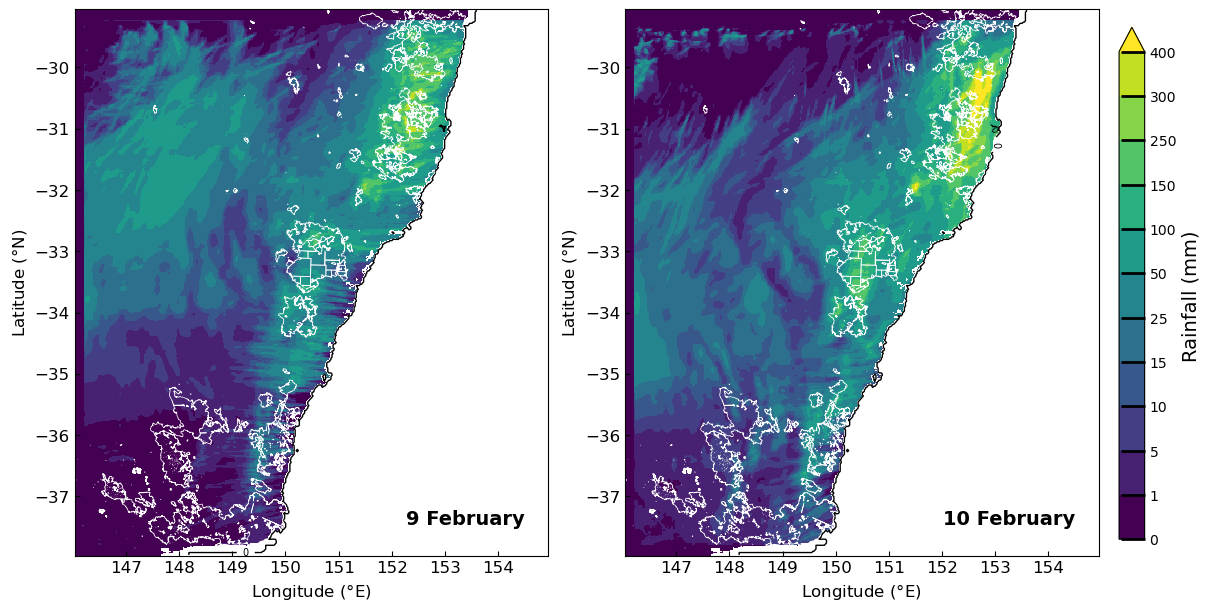

In [5]:
#control
#select date

# dates = ["2020-01-17", "2020-01-18"]
dates = ["2020-02-09", "2020-02-10"]
# titles = ["17 January", "18 January"]
titles = ["9 February", "10 February"]
levels = [0, 1, 5, 10, 15, 25, 50, 100, 150, 250, 300, 400]
fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
axes = axes.flatten()

for i, date in enumerate(dates):
    day = pd.Timestamp(date)
    
    #9am the day before to 8am on the day to match AGCD method
    start_time = day - pd.Timedelta(days=1) + pd.Timedelta(hours=9)
    end_time = day + pd.Timedelta(hours=8)
    
    #mm/s to mm/hr, sum
    hourly = da1_local.sel(time=slice(start_time, end_time)) * 3600  # mm/hr
    daily_total = hourly.sum(dim='time', skipna=True)
    daily_total = daily_total.where(landmask == 1)

    im = daily_total.plot(
        ax=axes[i],
        cmap="viridis",
        levels=levels,
        extend='max',
        add_colorbar=False
    )

    contours = sa1.plot.contour(
        ax=axes[i], levels=[0], colors='black', linewidths=1, add_colorbar=False
    )
    axes[i].clabel(contours, fmt='%d', fontsize=7)
    
    #fires to not skew map appearance
    xlim = axes[i].get_xlim()
    ylim = axes[i].get_ylim()
    aspect = axes[i].get_aspect()
    extent_poly = geom.box(xlim[0], ylim[0], xlim[1], ylim[1])
    fires_clipped = fires.clip(extent_poly)
    fires_clipped.boundary.plot(
        ax=axes[i],
        edgecolor='white',
        linewidth=0.5,
        aspect=aspect
    )
    axes[i].set_xlim(xlim)
    axes[i].set_ylim(ylim)
    axes[i].set_aspect(aspect)

    axes[i].set_title("")
    axes[i].text(
        0.95, 0.05, f"{titles[i]}",
        transform=axes[i].transAxes,
        fontsize=14,
        fontweight='bold',
        va='bottom',
        ha='right',
        color='black'
    )
    axes[i].set_xlabel("Longitude ($\\degree$E)", fontsize=12)
    axes[i].set_ylabel("Latitude ($\\degree$N)", fontsize=12)
    axes[i].tick_params(axis='both', direction='in', labelsize=12)

cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.02)
cbar.set_label("Rainfall (mm)", fontsize=14)
cbar.set_ticks(levels)
cbar.ax.tick_params(axis='y', width=2, direction='in', length=17)
# plt.savefig('/g/data/ng72/as9583/figures/event.png')

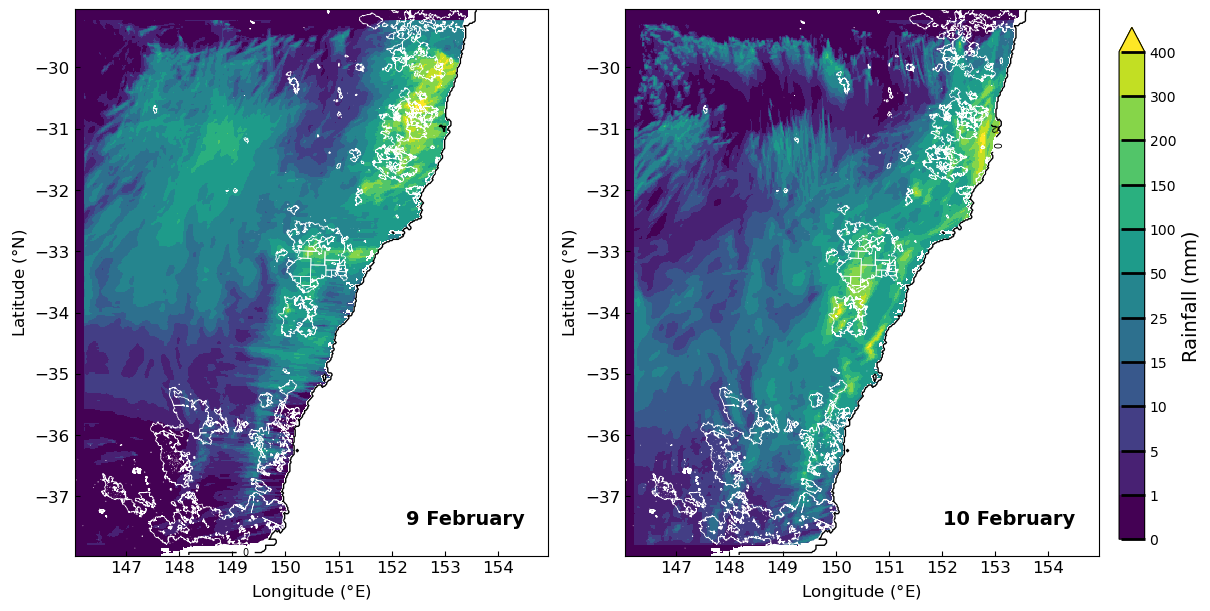

In [6]:
## allvar
# dates = ["2020-01-17", "2020-01-18"]
# titles = ["17 January", "18 January"]
dates = ["2020-02-09", "2020-02-10"]
titles = ["9 February", "10 February"]
levels = [0, 1, 5, 10, 15, 25, 50, 100, 150, 200, 300, 400]
fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
axes = axes.flatten()

for i, date in enumerate(dates):
    day = pd.Timestamp(date)
    
    #9am the day before to 8am on the day to match AGCD method
    start_time = day - pd.Timedelta(days=1) + pd.Timedelta(hours=9)
    end_time = day + pd.Timedelta(hours=8)
    
    #mm/s to mm/hr, sum
    hourly = da2_local.sel(time=slice(start_time, end_time)) * 3600  # mm/hr
    daily_total = hourly.sum(dim='time', skipna=True)
    daily_total = daily_total.where(landmask == 1)

    im = daily_total.plot(
        ax=axes[i],
        cmap="viridis",
        levels=levels,
        extend='max',
        add_colorbar=False
    )

    contours = sa1.plot.contour(
        ax=axes[i], levels=[0], colors='black', linewidths=1, add_colorbar=False
    )
    axes[i].clabel(contours, fmt='%d', fontsize=7)
    
    #fires to not skew map appearance
    xlim = axes[i].get_xlim()
    ylim = axes[i].get_ylim()
    aspect = axes[i].get_aspect()
    extent_poly = geom.box(xlim[0], ylim[0], xlim[1], ylim[1])
    fires_clipped = fires.clip(extent_poly)
    fires_clipped.boundary.plot(
        ax=axes[i],
        edgecolor='white',
        linewidth=0.5,
        aspect=aspect
    )
    axes[i].set_xlim(xlim)
    axes[i].set_ylim(ylim)
    axes[i].set_aspect(aspect)

    axes[i].set_title("")
    axes[i].text(
        0.95, 0.05, f"{titles[i]}",
        transform=axes[i].transAxes,
        fontsize=14,
        fontweight='bold',
        va='bottom',
        ha='right',
        color='black'
    )
    axes[i].set_xlabel("Longitude ($\\degree$E)", fontsize=12)
    axes[i].set_ylabel("Latitude ($\\degree$N)", fontsize=12)
    axes[i].tick_params(axis='both', direction='in', labelsize=12)

cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.02)
cbar.set_label("Rainfall (mm)", fontsize=14)
cbar.set_ticks(levels)
cbar.ax.tick_params(axis='y', width=2, direction='in', length=17)

## difference between experiment and control, (ex - cont), (ex/cont), Feb event

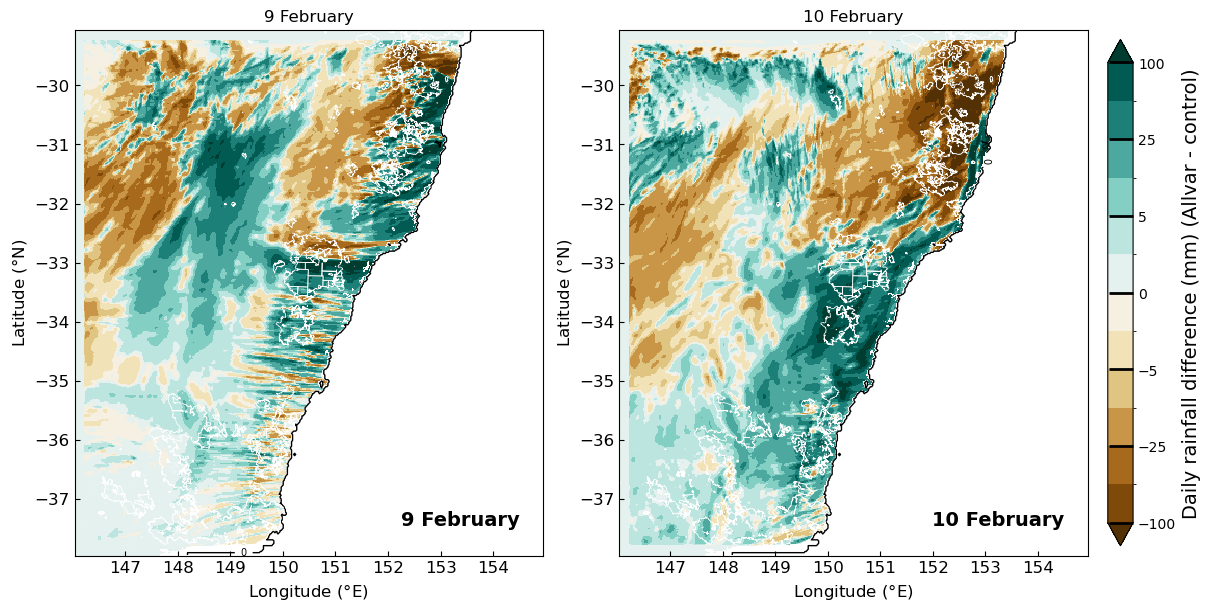

In [7]:
#difference
dates = ["2020-02-09", "2020-02-10"]
titles = ["9 February", "10 February"]

levels = [-100, -50, -25, -10, -5, -1, 0, 1, 5, 10, 25, 50, 100]

fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
axes = axes.flatten()

for i, date in enumerate(dates):
    day = pd.Timestamp(date)
    
    # 9am previous day to 8am current day
    start_time = day - pd.Timedelta(days=1) + pd.Timedelta(hours=9)
    end_time = day + pd.Timedelta(hours=8)
    
    control = (da1_local.sel(time=slice(start_time, end_time)) * 3600).sum(dim='time', skipna=True)
    SM = (da2_local.sel(time=slice(start_time, end_time)) * 3600).sum(dim='time', skipna=True)
    
    control = control.where(landmask == 1)
    SM = SM.where(landmask == 1)
    
    diff = SM - control

    #plot
    im = diff.plot(
        ax=axes[i],
        cmap="BrBG",
        levels=levels,
        extend='both',
        add_colorbar=False
    )

    #plot coastlines and fires
    contours = sa1.plot.contour(ax=axes[i], levels=[0], colors='black', linewidths=1, add_colorbar=False)
    axes[i].clabel(contours, fmt='%d', fontsize=7)
    
    xlim = axes[i].get_xlim()
    ylim = axes[i].get_ylim()
    aspect = axes[i].get_aspect()
    extent_poly = geom.box(xlim[0], ylim[0], xlim[1], ylim[1])
    fires_clipped = fires.clip(extent_poly)
    fires_clipped.boundary.plot(ax=axes[i], edgecolor='white', linewidth=0.5, aspect=aspect)
    axes[i].set_xlim(xlim)
    axes[i].set_ylim(ylim)
    axes[i].set_aspect(aspect)
    axes[i].set_title(titles[i])

    axes[i].text(0.95, 0.05, f"{titles[i]}", transform=axes[i].transAxes,
                 fontsize=14, fontweight='bold', va='bottom', ha='right', color='black')
    axes[i].set_xlabel("Longitude ($\\degree$E)", fontsize=12)
    axes[i].set_ylabel("Latitude ($\\degree$N)", fontsize=12)
    axes[i].tick_params(axis='both', direction='in', labelsize=12)

# shared colorbar
cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.02)
cbar.set_label("Daily rainfall difference (mm) (Allvar - control)", fontsize=14)
cbar.ax.tick_params(axis='y', width=2, direction='in', length=17)

plt.show()


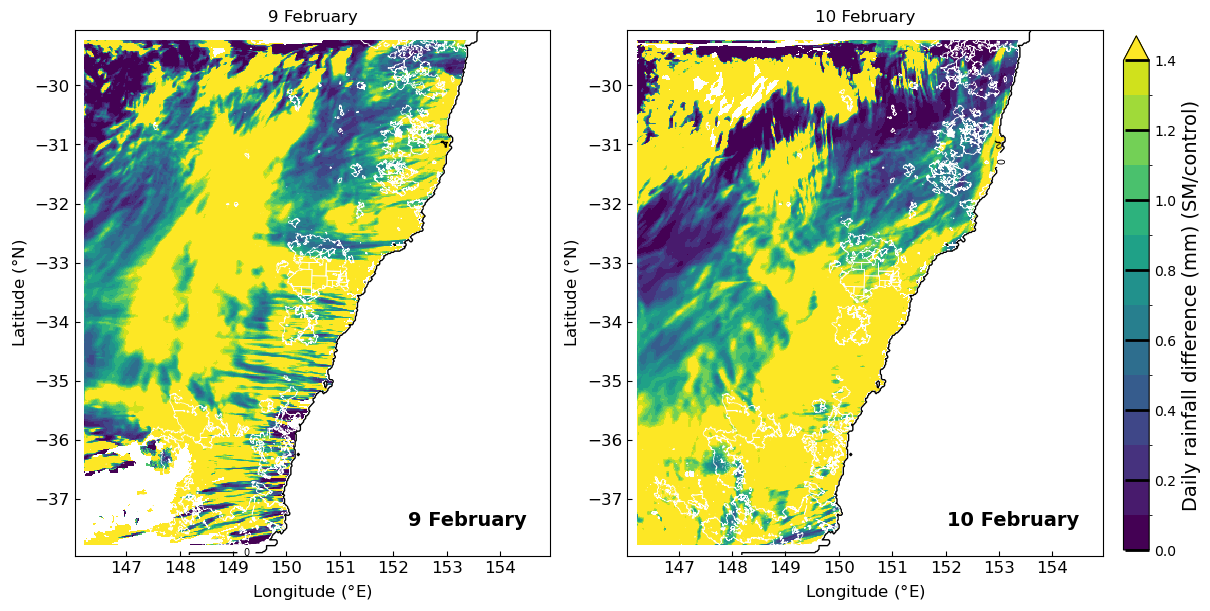

In [8]:
dates = ["2020-02-09", "2020-02-10"]
titles = ["9 February", "10 February"]

levels =np.arange(0,1.5,0.1)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
axes = axes.flatten()

for i, date in enumerate(dates):
    day = pd.Timestamp(date)
    
    #9am previous day to 8am current day
    start_time = day - pd.Timedelta(days=1) + pd.Timedelta(hours=9)
    end_time = day + pd.Timedelta(hours=8)
    
    control = (da1_local.sel(time=slice(start_time, end_time)) * 3600).sum(dim='time', skipna=True) #to mm/h
    SM = (da2_local.sel(time=slice(start_time, end_time)) * 3600).sum(dim='time', skipna=True)
    
    control = control.where(landmask == 1)
    SM = SM.where(landmask == 1)
    
    diff = SM / control

    #plot
    im = diff.plot(
        ax=axes[i],
        cmap="viridis",
        levels=levels,
        add_colorbar=False
    )

    contours = sa1.plot.contour(ax=axes[i], levels=[0], colors='black', linewidths=1, add_colorbar=False)
    axes[i].clabel(contours, fmt='%d', fontsize=7)
    
    xlim = axes[i].get_xlim()
    ylim = axes[i].get_ylim()
    aspect = axes[i].get_aspect()
    extent_poly = geom.box(xlim[0], ylim[0], xlim[1], ylim[1])
    fires_clipped = fires.clip(extent_poly)
    fires_clipped.boundary.plot(ax=axes[i], edgecolor='white', linewidth=0.5, aspect=aspect)
    axes[i].set_xlim(xlim)
    axes[i].set_ylim(ylim)
    axes[i].set_aspect(aspect)
    axes[i].set_title(titles[i])

    axes[i].text(0.95, 0.05, f"{titles[i]}", transform=axes[i].transAxes,
                 fontsize=14, fontweight='bold', va='bottom', ha='right', color='black')
    axes[i].set_xlabel("Longitude ($\\degree$E)", fontsize=12)
    axes[i].set_ylabel("Latitude ($\\degree$N)", fontsize=12)
    axes[i].tick_params(axis='both', direction='in', labelsize=12)

cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.02)
cbar.set_label("Daily rainfall difference (mm) (SM/control)", fontsize=14)
cbar.ax.tick_params(axis='y', width=2, direction='in', length=17)

plt.show()


### 10 feb, highlight times

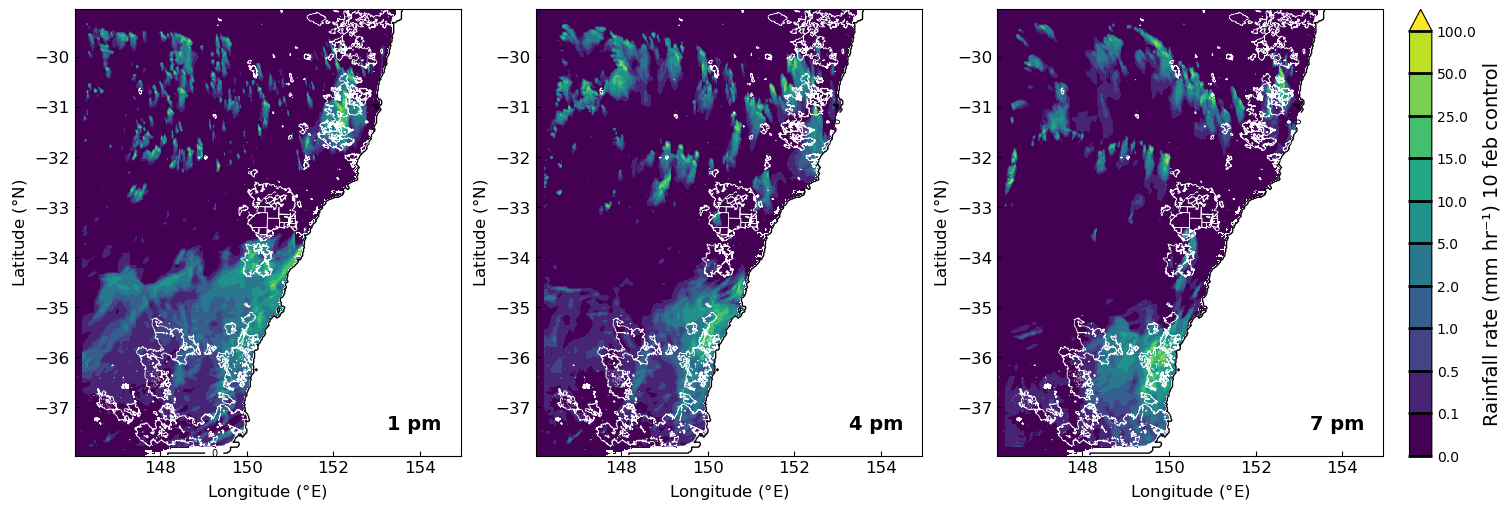

In [9]:
#10 feb, control

times = ["2020-02-10T13:00", "2020-02-10T16:00", "2020-02-10T19:00"]
titles = ["1 pm", "4 pm", "7 pm"]
levels = [0, 0.1, 0.5, 1, 2, 5, 10, 15, 25, 50, 100]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
axes = axes.flatten()

for i, t in enumerate(times):
    #to mm/h
    hourly = da1_local.sel(time=pd.Timestamp(t), method='nearest') * 3600
    hourly = hourly.where(landmask == 1)

    im = hourly.plot(
        ax=axes[i],
        cmap="viridis",
        levels=levels,
        extend='max',
        add_colorbar=False
    )

    #coastline
    contours = sa1.plot.contour(
        ax=axes[i], levels=[0], colors='black', linewidths=1, add_colorbar=False
    )
    axes[i].clabel(contours, fmt='%d', fontsize=7)

    #fires
    xlim = axes[i].get_xlim()
    ylim = axes[i].get_ylim()
    aspect = axes[i].get_aspect()
    extent_poly = geom.box(xlim[0], ylim[0], xlim[1], ylim[1])
    fires_clipped = fires.clip(extent_poly)
    fires_clipped.boundary.plot(ax=axes[i], edgecolor='white', linewidth=0.5, aspect=aspect)
    axes[i].set_xlim(xlim)
    axes[i].set_ylim(ylim)
    axes[i].set_aspect(aspect)

    axes[i].set_title("")
    axes[i].text(
        0.95, 0.05, f"{titles[i]}",
        transform=axes[i].transAxes,
        fontsize=14,
        fontweight='bold',
        va='bottom',
        ha='right',
        color='black'
    )

    axes[i].set_xlabel("Longitude ($\\degree$E)", fontsize=12)
    axes[i].set_ylabel("Latitude ($\\degree$N)", fontsize=12)
    axes[i].tick_params(axis='both', direction='in', labelsize=12)

cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.02)
cbar.set_label("Rainfall rate (mm hr⁻¹) 10 feb control", fontsize=14)
cbar.set_ticks(levels)
cbar.ax.tick_params(axis='y', width=2, direction='in', length=17)

plt.show()


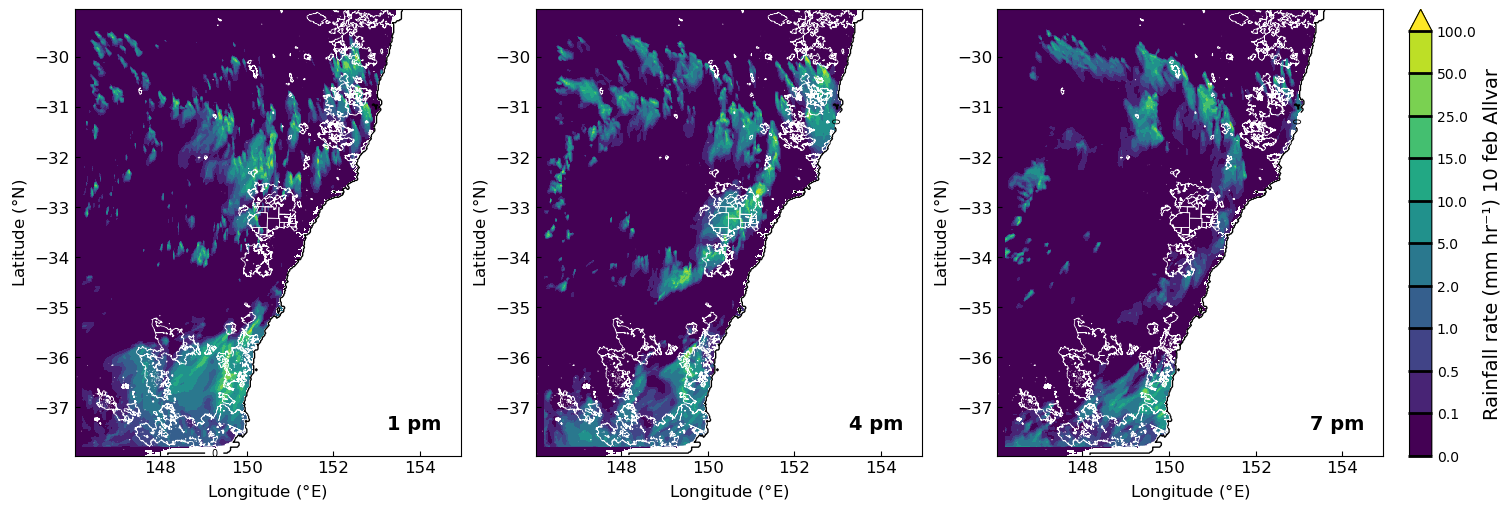

In [10]:
#10 feb, experiment

times = ["2020-02-10T13:00", "2020-02-10T16:00", "2020-02-10T19:00"]
titles = ["1 pm", "4 pm", "7 pm"]
levels = [0, 0.1, 0.5, 1, 2, 5, 10, 15, 25, 50, 100]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
axes = axes.flatten()

for i, t in enumerate(times):
    #to mm/h
    hourly = da2_local.sel(time=pd.Timestamp(t), method='nearest') * 3600
    hourly = hourly.where(landmask == 1)

    im = hourly.plot(
        ax=axes[i],
        cmap="viridis",
        levels=levels,
        extend='max',
        add_colorbar=False
    )

    #coastline 
    contours = sa1.plot.contour(
        ax=axes[i], levels=[0], colors='black', linewidths=1, add_colorbar=False
    )
    axes[i].clabel(contours, fmt='%d', fontsize=7)

    #fires
    xlim = axes[i].get_xlim()
    ylim = axes[i].get_ylim()
    aspect = axes[i].get_aspect()
    extent_poly = geom.box(xlim[0], ylim[0], xlim[1], ylim[1])
    fires_clipped = fires.clip(extent_poly)
    fires_clipped.boundary.plot(ax=axes[i], edgecolor='white', linewidth=0.5, aspect=aspect)
    axes[i].set_xlim(xlim)
    axes[i].set_ylim(ylim)
    axes[i].set_aspect(aspect)

    axes[i].set_title("")
    axes[i].text(
        0.95, 0.05, f"{titles[i]}",
        transform=axes[i].transAxes,
        fontsize=14,
        fontweight='bold',
        va='bottom',
        ha='right',
        color='black'
    )

    axes[i].set_xlabel("Longitude ($\\degree$E)", fontsize=12)
    axes[i].set_ylabel("Latitude ($\\degree$N)", fontsize=12)
    axes[i].tick_params(axis='both', direction='in', labelsize=12)

cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.02)
cbar.set_label("Rainfall rate (mm hr⁻¹) 10 feb Allvar", fontsize=14)
cbar.set_ticks(levels)
cbar.ax.tick_params(axis='y', width=2, direction='in', length=17)

plt.show()


### 9 feb, highlight times

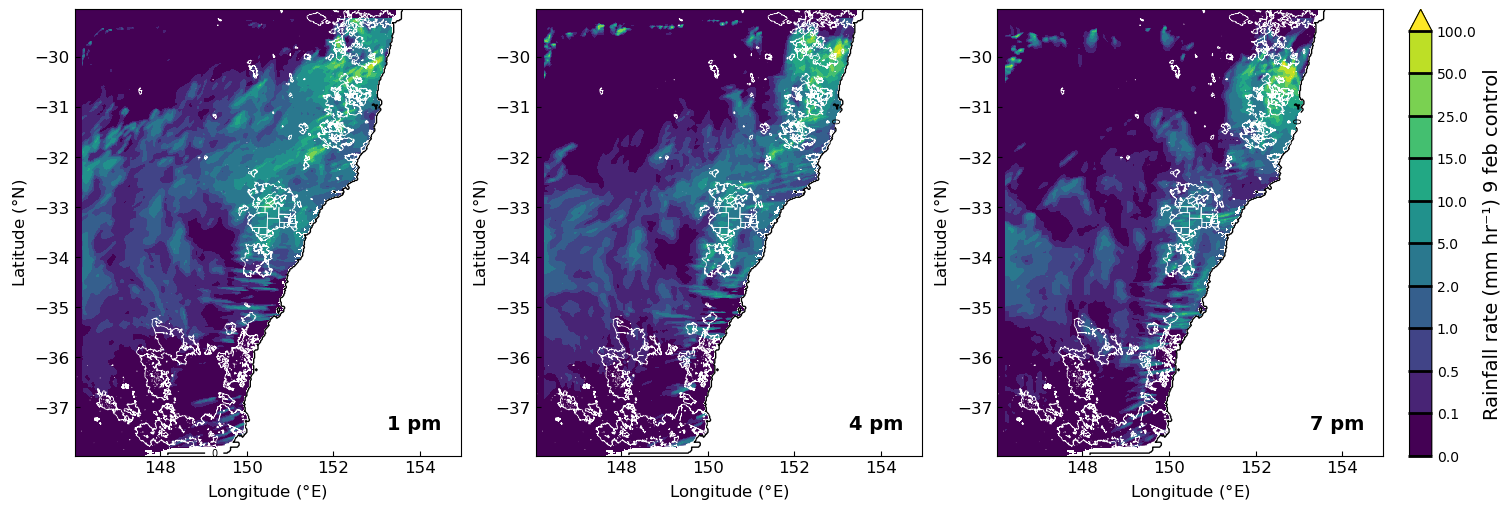

In [11]:
#9 feb, control
times = ["2020-02-09T13:00", "2020-02-09T16:00", "2020-02-09T19:00"]
titles = ["1 pm", "4 pm", "7 pm"]
levels = [0, 0.1, 0.5, 1, 2, 5, 10, 15, 25, 50, 100]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
axes = axes.flatten()

for i, t in enumerate(times):
    #to mm/h
    hourly = da1_local.sel(time=pd.Timestamp(t), method='nearest') * 3600
    hourly = hourly.where(landmask == 1)

    im = hourly.plot(
        ax=axes[i],
        cmap="viridis",
        levels=levels,
        extend='max',
        add_colorbar=False
    )

    #coastline
    contours = sa1.plot.contour(
        ax=axes[i], levels=[0], colors='black', linewidths=1, add_colorbar=False
    )
    axes[i].clabel(contours, fmt='%d', fontsize=7)

    #fire
    xlim = axes[i].get_xlim()
    ylim = axes[i].get_ylim()
    aspect = axes[i].get_aspect()
    extent_poly = geom.box(xlim[0], ylim[0], xlim[1], ylim[1])
    fires_clipped = fires.clip(extent_poly)
    fires_clipped.boundary.plot(ax=axes[i], edgecolor='white', linewidth=0.5, aspect=aspect)
    axes[i].set_xlim(xlim)
    axes[i].set_ylim(ylim)
    axes[i].set_aspect(aspect)

    axes[i].set_title("")
    axes[i].text(
        0.95, 0.05, f"{titles[i]}",
        transform=axes[i].transAxes,
        fontsize=14,
        fontweight='bold',
        va='bottom',
        ha='right',
        color='black'
    )

    axes[i].set_xlabel("Longitude ($\\degree$E)", fontsize=12)
    axes[i].set_ylabel("Latitude ($\\degree$N)", fontsize=12)
    axes[i].tick_params(axis='both', direction='in', labelsize=12)

cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.02)
cbar.set_label("Rainfall rate (mm hr⁻¹) 9 feb control", fontsize=14)
cbar.set_ticks(levels)
cbar.ax.tick_params(axis='y', width=2, direction='in', length=17)

plt.show()


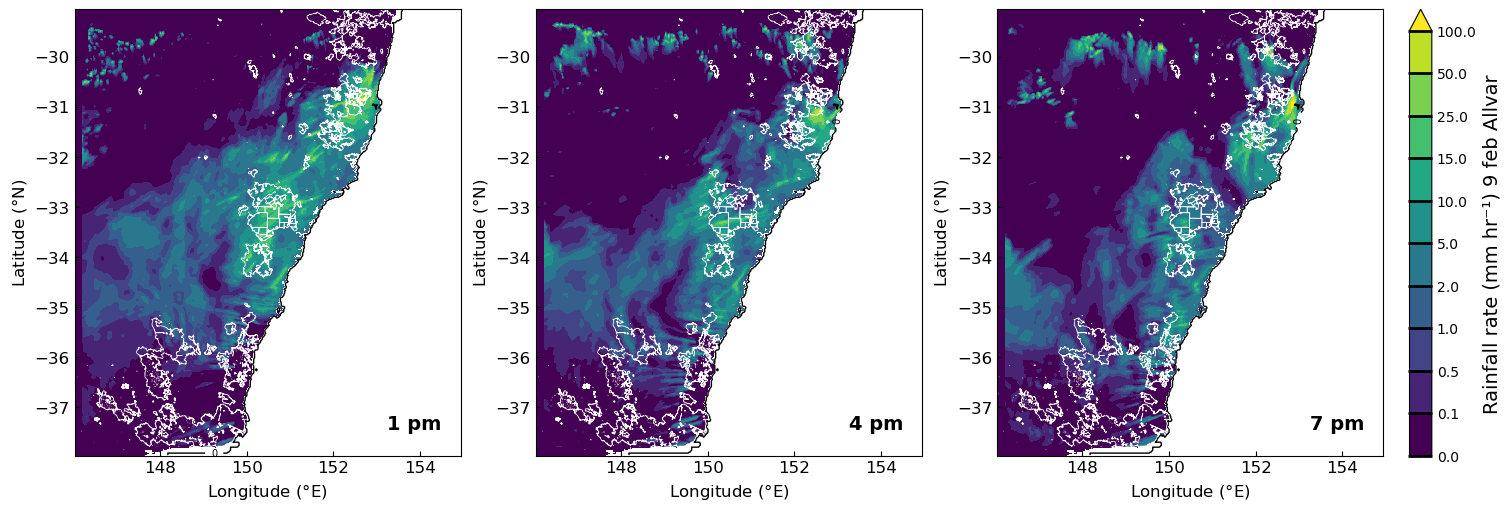

In [12]:
# 9 feb, experiment

times = ["2020-02-09T13:00", "2020-02-09T16:00", "2020-02-09T19:00"]
titles = ["1 pm", "4 pm", "7 pm"]
levels = [0, 0.1, 0.5, 1, 2, 5, 10, 15, 25, 50, 100]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
axes = axes.flatten()

for i, t in enumerate(times):
    #to mm/h
    hourly = da2_local.sel(time=pd.Timestamp(t), method='nearest') * 3600
    hourly = hourly.where(landmask == 1)

    im = hourly.plot(
        ax=axes[i],
        cmap="viridis",
        levels=levels,
        extend='max',
        add_colorbar=False
    )

    #coastline
    contours = sa1.plot.contour(
        ax=axes[i], levels=[0], colors='black', linewidths=1, add_colorbar=False
    )
    axes[i].clabel(contours, fmt='%d', fontsize=7)

    #fires
    xlim = axes[i].get_xlim()
    ylim = axes[i].get_ylim()
    aspect = axes[i].get_aspect()
    extent_poly = geom.box(xlim[0], ylim[0], xlim[1], ylim[1])
    fires_clipped = fires.clip(extent_poly)
    fires_clipped.boundary.plot(ax=axes[i], edgecolor='white', linewidth=0.5, aspect=aspect)
    axes[i].set_xlim(xlim)
    axes[i].set_ylim(ylim)
    axes[i].set_aspect(aspect)

    axes[i].set_title("")
    axes[i].text(
        0.95, 0.05, f"{titles[i]}",
        transform=axes[i].transAxes,
        fontsize=14,
        fontweight='bold',
        va='bottom',
        ha='right',
        color='black'
    )

    axes[i].set_xlabel("Longitude ($\\degree$E)", fontsize=12)
    axes[i].set_ylabel("Latitude ($\\degree$N)", fontsize=12)
    axes[i].tick_params(axis='both', direction='in', labelsize=12)

cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.02)
cbar.set_label("Rainfall rate (mm hr⁻¹) 9 feb Allvar", fontsize=14)
cbar.set_ticks(levels)
cbar.ax.tick_params(axis='y', width=2, direction='in', length=17)

plt.show()


### exact time, diffs, 10 feb

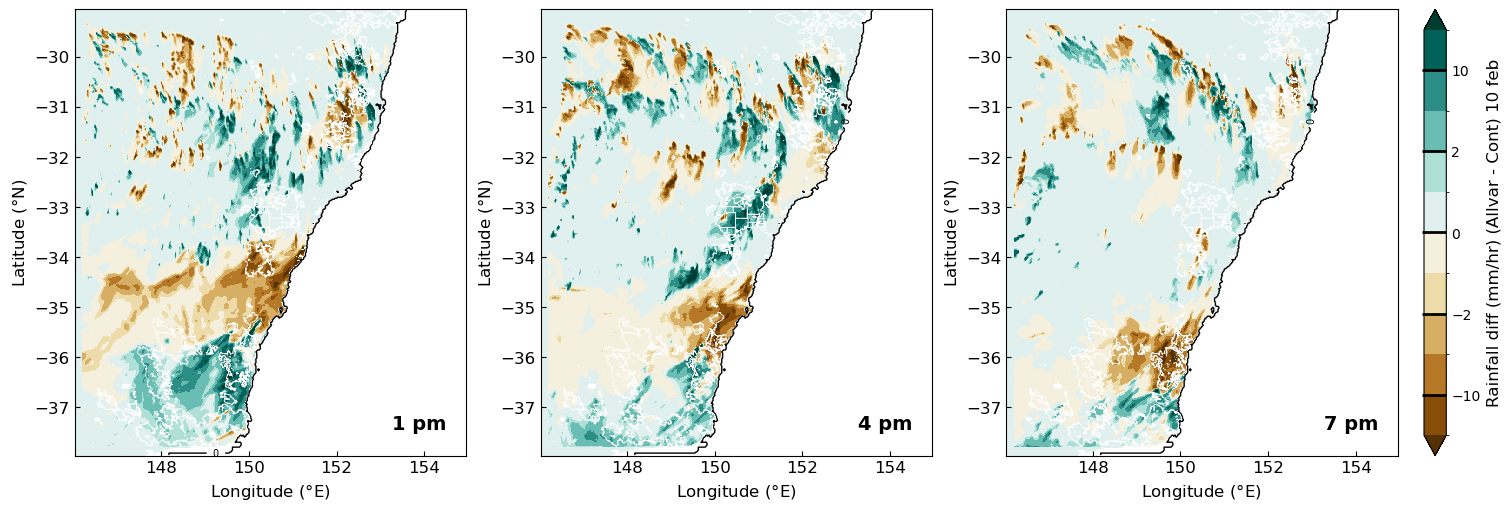

In [13]:
#10 feb

times = ["2020-02-10T13:00", "2020-02-10T16:00", "2020-02-10T19:00"]
titles = ["1 pm", "4 pm", "7 pm"]

levels = [-20, -10, -5, -2, -1, 0, 1, 2, 5, 10, 20]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
axes = axes.flatten()

for i, t in enumerate(times):
    #mm/h
    da1_hour = da1_local.sel(time=pd.Timestamp(t), method='nearest') * 3600
    da2_hour = da2_local.sel(time=pd.Timestamp(t), method='nearest') * 3600
    
    #diff exp - cont
    diff = (da2_hour - da1_hour).where(landmask == 1)

    im = diff.plot(
        ax=axes[i],
        cmap="BrBG",  
        levels=levels,
        add_colorbar=False
    )

    #coastline
    contours = sa1.plot.contour(
        ax=axes[i], levels=[0], colors='black', linewidths=1, add_colorbar=False
    )
    axes[i].clabel(contours, fmt='%d', fontsize=7)

    #fires
    xlim = axes[i].get_xlim()
    ylim = axes[i].get_ylim()
    aspect = axes[i].get_aspect()
    extent_poly = geom.box(xlim[0], ylim[0], xlim[1], ylim[1])
    fires_clipped = fires.clip(extent_poly)
    fires_clipped.boundary.plot(ax=axes[i], edgecolor='white', linewidth=0.5, aspect=aspect)
    axes[i].set_xlim(xlim)
    axes[i].set_ylim(ylim)
    axes[i].set_aspect(aspect)

    axes[i].set_title("")
    axes[i].text(
        0.95, 0.05, f"{titles[i]}",
        transform=axes[i].transAxes,
        fontsize=14,
        fontweight='bold',
        va='bottom',
        ha='right',
        color='black'
    )

    axes[i].set_xlabel("Longitude ($\\degree$E)", fontsize=12)
    axes[i].set_ylabel("Latitude ($\\degree$N)", fontsize=12)
    axes[i].tick_params(axis='both', direction='in', labelsize=12)

cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.02)
cbar.set_label("Rainfall diff (mm/hr) (Allvar - Cont) 10 feb", fontsize=12)
cbar.ax.tick_params(axis='y', width=2, direction='in', length=17)

plt.show()


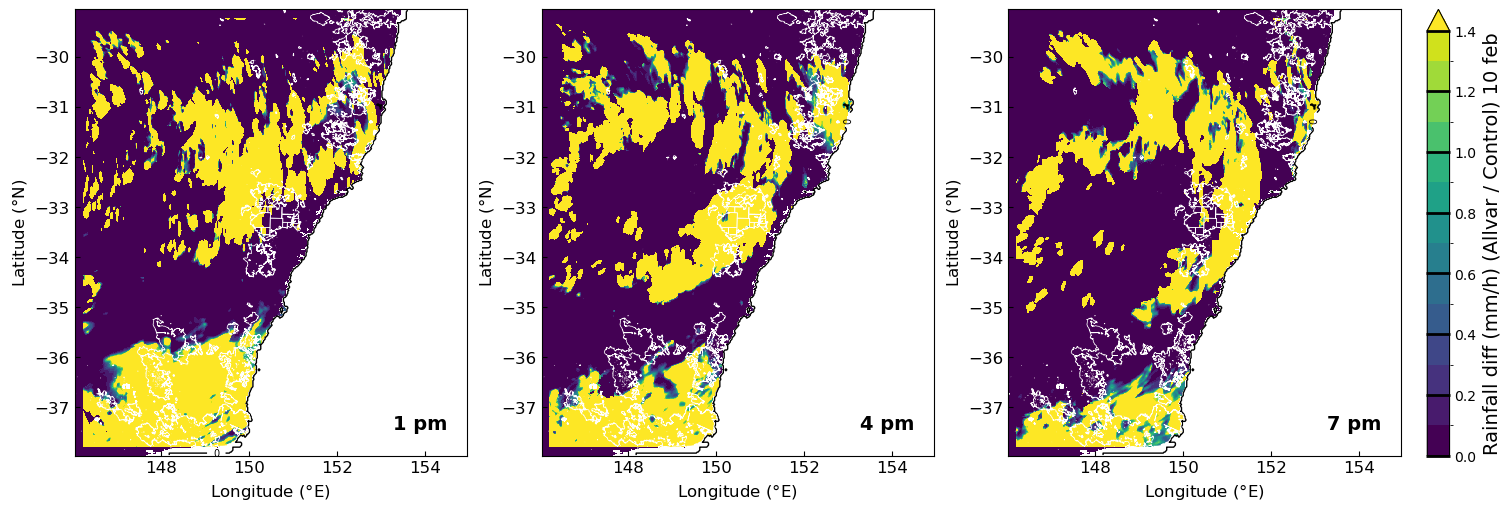

In [14]:
# ratio diff, 10 feb
times = ["2020-02-10T13:00", "2020-02-10T16:00", "2020-02-10T19:00"]
titles = ["1 pm", "4 pm", "7 pm"]

levels =np.arange(0,1.5,0.1)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
axes = axes.flatten()

for i, t in enumerate(times):
    #mm/h
    da1_hour = da1_local.sel(time=pd.Timestamp(t), method='nearest') * 3600
    da2_hour = da2_local.sel(time=pd.Timestamp(t), method='nearest') * 3600
    
    #diff above 0/0
    da1_safe = da1_hour.clip(min=1e-6)
    diff = (da2_hour / da1_safe).where(landmask == 1)

    im = diff.plot(
        ax=axes[i],
        cmap="viridis", 
        levels=levels,
        add_colorbar=False
    )

    #coastline
    contours = sa1.plot.contour(
        ax=axes[i], levels=[0], colors='black', linewidths=1, add_colorbar=False
    )
    axes[i].clabel(contours, fmt='%d', fontsize=7)

    #fires
    xlim = axes[i].get_xlim()
    ylim = axes[i].get_ylim()
    aspect = axes[i].get_aspect()
    extent_poly = geom.box(xlim[0], ylim[0], xlim[1], ylim[1])
    fires_clipped = fires.clip(extent_poly)
    fires_clipped.boundary.plot(ax=axes[i], edgecolor='white', linewidth=0.5, aspect=aspect)
    axes[i].set_xlim(xlim)
    axes[i].set_ylim(ylim)
    axes[i].set_aspect(aspect)

    axes[i].set_title("")
    axes[i].text(
        0.95, 0.05, f"{titles[i]}",
        transform=axes[i].transAxes,
        fontsize=14,
        fontweight='bold',
        va='bottom',
        ha='right',
        color='black'
    )

    axes[i].set_xlabel("Longitude ($\\degree$E)", fontsize=12)
    axes[i].set_ylabel("Latitude ($\\degree$N)", fontsize=12)
    axes[i].tick_params(axis='both', direction='in', labelsize=12)

cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.02)
cbar.set_label("Rainfall diff (mm/h) (Allvar / Control) 10 feb", fontsize=14)
cbar.ax.tick_params(axis='y', width=2, direction='in', length=17)

plt.show()


### exact time diff, 9 feb

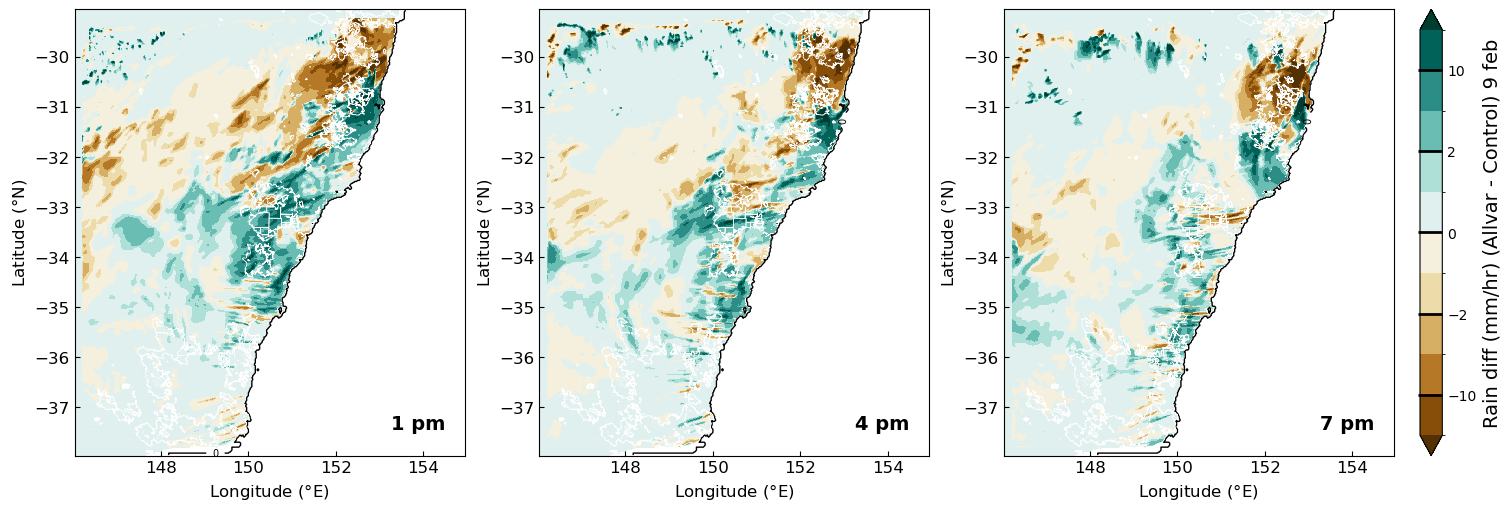

In [15]:
#absolute diff
times = ["2020-02-09T13:00", "2020-02-09T16:00", "2020-02-09T19:00"]
titles = ["1 pm", "4 pm", "7 pm"]

levels = [-20, -10, -5, -2, -1, 0, 1, 2, 5, 10, 20]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
axes = axes.flatten()

for i, t in enumerate(times):
    #mm/h
    da1_hour = da1_local.sel(time=pd.Timestamp(t), method='nearest') * 3600
    da2_hour = da2_local.sel(time=pd.Timestamp(t), method='nearest') * 3600
    
    #diff
    diff = (da2_hour - da1_hour).where(landmask == 1)

    im = diff.plot(
        ax=axes[i],
        cmap="BrBG", 
        levels=levels,
        add_colorbar=False
    )

    #coastline
    contours = sa1.plot.contour(
        ax=axes[i], levels=[0], colors='black', linewidths=1, add_colorbar=False
    )
    axes[i].clabel(contours, fmt='%d', fontsize=7)

    #fires
    xlim = axes[i].get_xlim()
    ylim = axes[i].get_ylim()
    aspect = axes[i].get_aspect()
    extent_poly = geom.box(xlim[0], ylim[0], xlim[1], ylim[1])
    fires_clipped = fires.clip(extent_poly)
    fires_clipped.boundary.plot(ax=axes[i], edgecolor='white', linewidth=0.5, aspect=aspect)
    axes[i].set_xlim(xlim)
    axes[i].set_ylim(ylim)
    axes[i].set_aspect(aspect)

    axes[i].set_title("")
    axes[i].text(
        0.95, 0.05, f"{titles[i]}",
        transform=axes[i].transAxes,
        fontsize=14,
        fontweight='bold',
        va='bottom',
        ha='right',
        color='black'
    )

    axes[i].set_xlabel("Longitude ($\\degree$E)", fontsize=12)
    axes[i].set_ylabel("Latitude ($\\degree$N)", fontsize=12)
    axes[i].tick_params(axis='both', direction='in', labelsize=12)

cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.02)
cbar.set_label("Rain diff (mm/hr) (Allvar - Control) 9 feb", fontsize=14)
cbar.ax.tick_params(axis='y', width=2, direction='in', length=17)

plt.show()


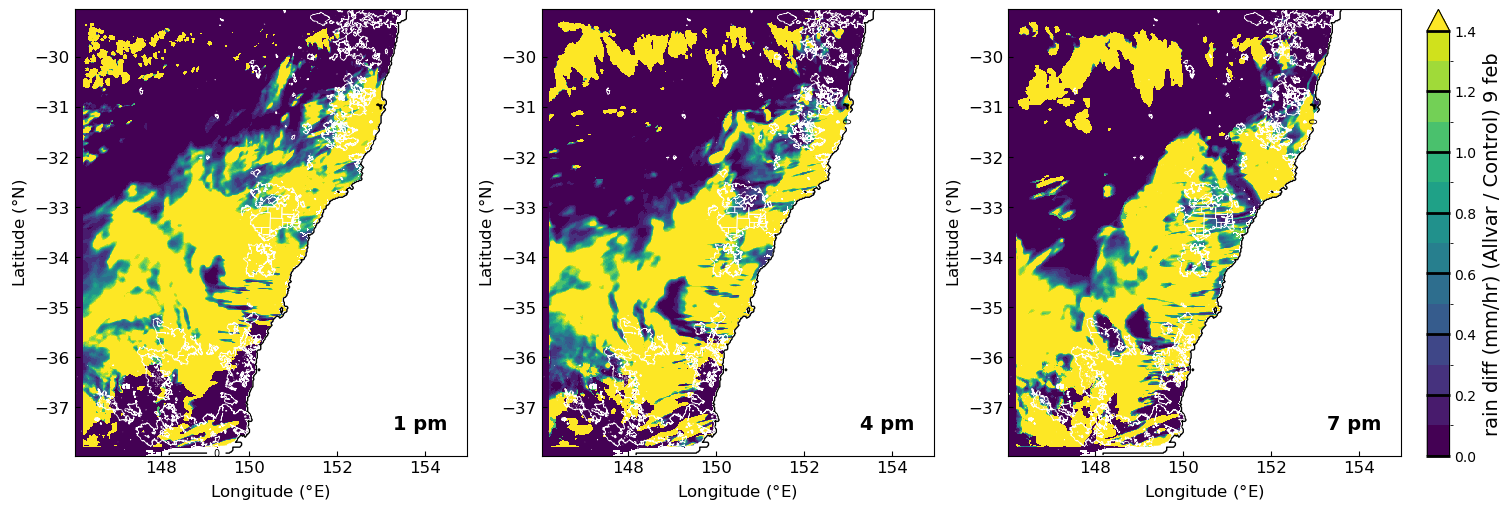

In [16]:
#relative diff
times = ["2020-02-09T13:00", "2020-02-09T16:00", "2020-02-09T19:00"]
titles = ["1 pm", "4 pm", "7 pm"]

levels =np.arange(0,1.5,0.1)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
axes = axes.flatten()

for i, t in enumerate(times):
    #mm/h
    da1_hour = da1_local.sel(time=pd.Timestamp(t), method='nearest') * 3600
    da2_hour = da2_local.sel(time=pd.Timestamp(t), method='nearest') * 3600

    #diff above 0/0
    da1_safe = da1_hour.clip(min=1e-6) ## removing NaN 
    diff = (da2_hour / da1_safe).where(landmask == 1)

    im = diff.plot(
        ax=axes[i],
        cmap="viridis",  # diverging colormap for ±
        levels=levels,
        # extend='both',
        add_colorbar=False
    )

    #coastline
    contours = sa1.plot.contour(
        ax=axes[i], levels=[0], colors='black', linewidths=1, add_colorbar=False
    )
    axes[i].clabel(contours, fmt='%d', fontsize=7)

    #fires
    xlim = axes[i].get_xlim()
    ylim = axes[i].get_ylim()
    aspect = axes[i].get_aspect()
    extent_poly = geom.box(xlim[0], ylim[0], xlim[1], ylim[1])
    fires_clipped = fires.clip(extent_poly)
    fires_clipped.boundary.plot(ax=axes[i], edgecolor='white', linewidth=0.5, aspect=aspect)
    axes[i].set_xlim(xlim)
    axes[i].set_ylim(ylim)
    axes[i].set_aspect(aspect)

    axes[i].set_title("")
    axes[i].text(
        0.95, 0.05, f"{titles[i]}",
        transform=axes[i].transAxes,
        fontsize=14,
        fontweight='bold',
        va='bottom',
        ha='right',
        color='black'
    )

    axes[i].set_xlabel("Longitude ($\\degree$E)", fontsize=12)
    axes[i].set_ylabel("Latitude ($\\degree$N)", fontsize=12)
    axes[i].tick_params(axis='both', direction='in', labelsize=12)

cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.02)
cbar.set_label("rain diff (mm/hr) (Allvar / Control) 9 feb", fontsize=14)
cbar.ax.tick_params(axis='y', width=2, direction='in', length=17)

plt.show()
